In [1]:
import cv2
import numpy as np

def preprocess_image(gray):
    """
    Preprocess the grayscale image to a clean binary image:
      - Gaussian blur to reduce noise.
      - Otsu's threshold to binarize (white text on black).
      - Morphological opening/closing to clean up.
    """
    # Blur to smooth out noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Otsu's threshold: automatic binarization (invert for white-on-black text)
    _, thresh = cv2.threshold(blurred, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Morphological opening (remove small white noise)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # Morphological closing (fill small black holes inside letters)
    clean = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return clean


In [13]:
def segment_characters(binary_img):
    """
    Find contours in the binary image and return bounding boxes for characters,
    sorted from top-left to bottom-right.
    """
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Filter very small/large boxes
        if w > 5 and h > 10:
            boxes.append((x, y, w, h))
    # Sort by y (row), then by x (column) for reading order
    boxes = sorted(boxes, key=lambda b: (b[1], b[0]))
    return boxes


In [19]:
import numpy as np
from tensorflow.keras.models import load_model

# Assume models are pre-loaded (two separate CNNs)
#model_char = load_model('char_classification_model.h5')   # A-Z classifier
model_rev  = load_model('reversal_detector.h5')    # binary normal/reversal

def prepare_roi_cnn(gray, box, size=64):
    """Crop ROI from grayscale image, resize with aspect ratio, pad to (size, size), add channel."""
    x, y, w, h = box
    roi = gray[y:y+h, x:x+w]

    # Resize keeping aspect ratio
    scale = min(size / w, size / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(roi, (new_w, new_h))

    # Pad to 64x64
    pad_w = (size - new_w) // 2
    pad_h = (size - new_h) // 2
    padded = cv2.copyMakeBorder(resized, pad_h, size - new_h - pad_h,
                                pad_w, size - new_w - pad_w,
                                cv2.BORDER_CONSTANT, value=0)

    # Normalize and reshape to (1, 64, 64, 1)
    normalized = padded.astype("float32") / 255.0
    return normalized.reshape(1, size, size, 1)



def predict_reversal(gray, box):
    """
    Returns 'Reversal' or 'Normal' for the given character bounding box.
    """
    roi_input = prepare_roi(gray, box)           # (1, 32, 32, 1)
    flat_input = roi_input.reshape((1, -1))      # (1, 32*32*1 = 1024)

# If your model was trained on 4608 features, this still won't match.
# So you likely need to resize to 64x36 (or whatever original image size was used)

# Let's match to (1, 4608) exactly
    resized = cv2.resize(roi_input[0, :, :, 0], (64, 72))  # 64x72 = 4608
    normalized = resized.astype('float32') / 255.0
    flat_input = normalized.reshape((1, -1))               # Now (1, 4608)

    rev_prob = model_rev.predict(flat_input)[0][0]

    return "Reversal" if rev_prob > 0.5 else "Normal"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[1] Box=(0, 0, 74, 121) → Normal


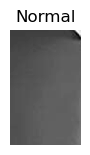

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[2] Box=(229, 0, 573, 487) → Normal


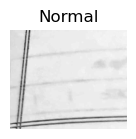

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[3] Box=(3037, 98, 580, 242) → Normal


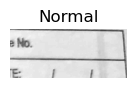

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[4] Box=(3075, 146, 58, 42) → Normal


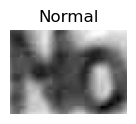

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[5] Box=(3019, 157, 36, 29) → Normal


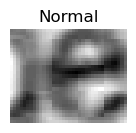

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[6] Box=(3004, 158, 9, 19) → Normal


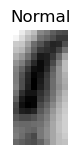

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[7] Box=(2951, 159, 22, 13) → Normal


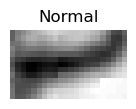

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[8] Box=(2909, 209, 29, 39) → Normal


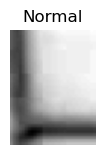

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[9] Box=(0, 231, 3840, 1929) → Normal


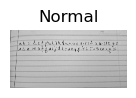

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[10] Box=(3438, 301, 7, 30) → Normal


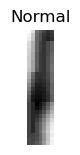

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[11] Box=(3051, 309, 22, 11) → Normal


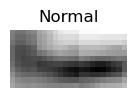

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[12] Box=(3613, 348, 7, 27) → Normal


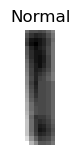

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[13] Box=(3080, 389, 540, 12) → Normal


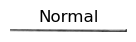

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4055: error: (-215:Assertion failed) inv_scale_x > 0 in function 'cv::resize'


In [21]:
import cv2
import matplotlib.pyplot as plt

# Load and preprocess
img_path = r'D:\STUDY\Sumit\lectures sumit\college\Major Project\test.jpeg'
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Cannot load {img_path}")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = preprocess_image(gray)         # as defined earlier
boxes = segment_characters(binary)      # as defined earlier

for i, (x, y, w, h) in enumerate(boxes, 1):
    roi_input = prepare_roi_cnn(gray, (x, y, w, h), size=64)
    rev_prob = model_rev.predict(roi_input)[0, 0]
    status = "Reversal" if rev_prob > 0.5 else "Normal"

    print(f"[{i}] Box={x,y,w,h} → {status}")
    
    # Optional: show the character
    roi = gray[y:y+h, x:x+w]
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(roi, cmap='gray')
    plt.title(status)
    plt.axis('off')
    plt.show()



In [16]:
# Inspect the first layer’s expected input shape
print("Reversal model input shape:", model_rev.input_shape)


Reversal model input shape: (None, 64, 64, 1)
